In TensorFlow Eager Exection is an imperative programming enviroment that evaluates operations immediately, without buliding graph.

This Eager execution is a flixible machine learining platfrom for research and exprimentation and this eager execution supports most Tensorflow operations and GPU acceleration.

*   An intuitive interface - Quickly iterate on small models and small data using Python Data structures.

*   Easier debugging - Use standard Python debugging tools for immediate error reporting and call ops directly to inspect running models and test changes.

*   Natural control flow - Use the Python control flow instead of graph control flow, simplifying the specification of dynamic models.




Basic Usage and Setup


In [ ]:
import os
import tensorflow as tf
import cProfile 

In [ ]:
tf.executing_eagerly()

True

In [ ]:
x = [[2.]]

m = tf.matmul(x, x)

print("Hello, {}".format(m))

Hello, [[4.]]


Eager works NumPy.NumPy operations accept tf.Tensor arguments. The tf.Tensor.numpy retruns the object's value as a NumPy ndarray and The tf.math operation convert Python object and NumPy arrays to tf.Tensor object.


In [ ]:
x = tf.constant([[1, 2],
                  [3, 4]])
print(x)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [ ]:
y = tf.add(x, 1)
print(y) # Boardcasting support

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [ ]:
print(x * y)# supporting Operator overloading

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [ ]:
import numpy as np

z = np.multiply(x, y)

print(z) # using numpy


[[ 2  6]
 [12 20]]


In [ ]:
print(x.numpy())

[[1 2]
 [3 4]]


#Dynamic Control flow

Eager execution supports all functionality of the host language is avilable while model executing.

In [ ]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [ ]:
fizzbuzz(25)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz
16
17
Fizz
19
Buzz
Fizz
22
23
Fizz
Buzz


# Eager training

During eager execution, use tf.GradientTape to trace operations for computing gradients later.

Use tf.GradientTape to train and/or compute gradients in eager. It is especially useful for complicated training loops.

A particular tf.GradientTape can only compute one gradient, subsequent calls throw a runtime error.

In [ ]:
w = tf.Variable([[1.0]])

with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


# Train a model

Demonstrates the optimizer and layer APIs to bulid trainable graphs in an eager exection enviroment.

In [ ]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [ ]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.02314494  0.14783508  0.00726267  0.04659688 -0.05418317  0.02697236
  -0.02268353  0.04598829  0.00941003 -0.11583567]]


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [ ]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)

    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [ ]:
def train(epochs):
  for epoch in range(epochs):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

In [ ]:
train(epochs = 3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

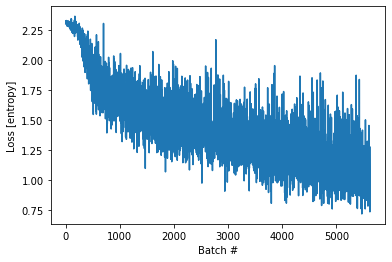

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

# Variables and optimizers

tf.Variable obejct store mutable tf.Tensor like values accessed during training to make automatic differentiation easier.

The collection of variables can be encapsulated into layers or models along with methods that operate on them.

The main difference between layer and models is that models add method are like

Model.fit, Model.evaluate and Model.save

In [ ]:
class Linear(tf.keras.Model):
  def __init__(self):
    super(Linear, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

In [ ]:
# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

Next steps:


1.   Create the model
2.   The Derivatives of a loss function  with respect to model parameters.
3.   A Strategy for updating the varibles based on the derivatives.



In [ ]:
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

steps = 300
for i in range(steps):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

Initial loss: 69.620
Loss at step 000: 66.869
Loss at step 020: 30.058
Loss at step 040: 13.816
Loss at step 060: 6.648
Loss at step 080: 3.483
Loss at step 100: 2.086
Loss at step 120: 1.468
Loss at step 140: 1.196
Loss at step 160: 1.075
Loss at step 180: 1.022
Loss at step 200: 0.998
Loss at step 220: 0.988
Loss at step 240: 0.983
Loss at step 260: 0.981
Loss at step 280: 0.980


In [ ]:
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Final loss: 0.980


In [ ]:
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

W = 2.990598440170288, B = 2.0311598777770996


# Obejct- based saving

Using tf.keras.Model includes a convenient save_weights methods allowing to easily create a checkpoint.

In [ ]:
model.save_weights('weights')
status = model.load_weights('weights')

tf.train.Checkpoint helps to take full control over this process

In [ ]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [ ]:
x.assign(2.)   # Assign a new value to the variables and save.
checkpoint_path = './ckpt/'
checkpoint.save(checkpoint_path)

'./ckpt/-1'

In [ ]:
x.assign(11.)  # Change the variable after saving.

# Restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


With the help of tf.train.Checkpoints we can save and load models and it store the internal state of objects without requiring hidden variables.

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Object-oriented metrics

Update a metric by passing the new data to the callable, and retrive the result using the tf.keras.metrics.result method and here it stored as object.

In [ ]:
m = tf.keras.metrics.Mean("loss")
m(0)
m(5)
m.result()  # => 2.5
m([8, 9])
m.result()  # => 5.5

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

# Summaries and TensorBoard

Using these TensorBoard we can esaly understanding, debugging and optimizing the model training process.

In eager execution we can summaries of variable using tf.summary

In [ ]:
logdir = "./tb/"
writer = tf.summary.create_file_writer(logdir)

steps = 1000
with writer.as_default():  # or call writer.set_as_default() before the loop.
  for i in range(steps):
    step = i + 1
    # Calculate loss with your real train function.
    loss = 1 - 0.001 * step
    if step % 100 == 0:
      tf.summary.scalar('loss', loss, step=step)

In [ ]:
ls tb/

events.out.tfevents.1621506596.cdecd3a919f8.58.636600.v2


# Advanced automatic differentiation topics

**Dynamic models**

In dynamic models we can use tf.GradientTape.


In [ ]:
def line_search_step(fn, init_x, rate=1.0):
  with tf.GradientTape() as tape:
    # Variables are automatically tracked.
    # But to calculate a gradient from a tensor, you must `watch` it.
    tape.watch(init_x)
    value = fn(init_x)
  grad = tape.gradient(value, init_x)
  grad_norm = tf.reduce_sum(grad * grad)
  init_value = value
  while value > init_value - rate * grad_norm:
    x = init_x - rate * grad
    value = fn(x)
    rate /= 2.0
  return x, value

# Custom gradients
Custom gradients is the easy way to override gradients.



In [ ]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
  y = tf.identity(x)
  def grad_fn(dresult):
    return [tf.clip_by_norm(dresult, norm), None]
  return y, grad_fn

In [ ]:
def log1pexp(x):
  return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)

In [ ]:
# The gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [ ]:
# However, x = 100 fails because of numerical instability.
grad_log1pexp(tf.constant(100.)).numpy()

nan

The implementation below reuses the value for tf.exp(x) that is computed during the forward pass making it more efficient by elimainating redundant calculatinos

In [ ]:
@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)


In [ ]:
# As before, the gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [ ]:
# And the gradient computation also works at x = 100.
grad_log1pexp(tf.constant(100.)).numpy()

1.0

# Performance


tf.matmul can return before completing the matrix multiplication
(e.g., can return after enqueing the operation on a CUDA stream).
The x.numpy() call below will ensure that all enqueued operations have completed and will also copy the result to host memory, so we're including a little more than just the matmul operation
time.

In [ ]:
import time

def measure(x, steps):
  # TensorFlow initializes a GPU the first time and exclude from timing.
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
  print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# Run on GPU, if available:
if tf.config.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
  print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 6.50298810005188 secs
GPU: not found


In [ ]:
if tf.config.list_physical_devices("GPU"):
  x = tf.random.normal([10, 10])

  x_gpu0 = x.gpu()
  x_cpu = x.cpu()

  _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
  _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0

Compute-heavy models such as ResNet50 training on a GPU execution performance is comparable to tf.function execution.